## Team_members:Naresh Kumar Gurulingan, Pradheep Krishna Muthukrishnan Padmanabhan, Sathiya Ramesh

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import random as rand
import matplotlib.pyplot as plt
import numpy as np

## Task 1: obtaining the MNIST dataset: 

In [2]:
'''
STEP 1: LOADING DATASET
'''
 
train_dataset = dsets.MNIST(root='./MNIST-data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./MNIST-data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [3]:
class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, 
                algorithm_name='LogisticRegression',
                train_batch_size=1000, num_epochs=10,
                learning_rate=0.001, optimizer=torch.optim.Adam):
        
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        parameters = self.linear.parameters()
        algorithm_to_loss = {
            'LogisticRegression': nn.CrossEntropyLoss(),
            'SVM': self.hingeLoss}
        
        if not any(algorithm_name==algorithm
                   for algorithm in algorithm_to_loss.keys()):
            raise ValueError ('{} not currently supported', algorithm_name)
        else:
            self.criterion = algorithm_to_loss[algorithm_name]
        
        self.batch_size = train_batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.optimizer = optimizer
             
    def forward(self, x):
        return self.linear(x)
    
    def hingeLoss(self, logits, targets):
        
#         zero = torch.Tensor([0]) 
#         targets = targets.long()
#         score_target_class = logits.gather(1, targets.view(-1,1))  # scores of the target class
#         targets = targets.view(-1,1)
#         ones = torch.Tensor([1])
#         loss = torch.sum(torch.max(zero, logits - score_target_class + 1.0), dim =1)
#         loss = loss - ones
#         loss = torch.mean(loss) # Getting the mean loss
#         return loss
        targets = targets.long()
        loss= torch.max(torch.tensor([0.]),logits-logits.gather(1, targets.unsqueeze(1))+1)
        dim1 = torch.arange(0, targets.shape[0], out=torch.LongTensor())
        labels=targets.long()
        idx=(dim1,labels)
        loss.index_put_(idx, torch.tensor([0.]))  
        #loss=torch.pow(loss,2)
        return torch.mean(torch.sum(loss,dim=1))
    
    def fit_and_evaluate(self, model, train_dataset, test_data, test_labels):
        
        optimizer = self.optimizer(model.parameters(), lr=self.learning_rate)
        
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=self.batch_size, 
                                           shuffle=True)
        
        for epoch in range(self.num_epochs):
            for images, labels in train_loader:
                images = Variable(images.view(-1, 28*28))
                labels = Variable(labels)

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = self.forward(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = self.criterion(outputs, labels)

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()
            
            test_images = Variable(test_data.view(-1, 28*28))
            outputs = self.forward(test_images.type(torch.FloatTensor))
            
            accuracy = self.get_accuracy(outputs, test_labels)

            # Print Loss
            print('Epoch: {}. Training Loss: {}. Test Accuracy: {}'.format(
                            epoch+1, loss.data, accuracy))
            
    def get_accuracy(self, outputs, labels, get_pred_conf=False):
        
        _, predicted = torch.max(outputs.data, 1)
        accuracy = 100. * float((predicted.cpu() == 
                             labels.cpu()).sum()) / len(labels)
        
        if get_pred_conf:
            raw_preds = outputs.data.numpy()
            return accuracy, predicted.numpy(), np.max(raw_preds, axis=1)

        return accuracy
           
    def generate_adversarial(self, model, image_tensor, image_labels,
                             epsilon=0.1):
        
        images = image_tensor.type(torch.FloatTensor)/255
        images = Variable(images.view(-1, 28*28),
                              requires_grad=True)

        outputs = self.forward(images)
        loss = self.criterion(outputs, image_labels)
        loss.backward()
        gradients   = torch.sign(images.grad.data)
        adversarial_images = torch.clamp(images.data + epsilon * gradients, 0., 1.)
        
        return images, adversarial_images
    
    def plot(self, image, adversarial, img_title, adv_title):
        fig = plt.figure()
        fig.add_subplot(121)
        image = np.reshape(image, (28, 28)) * 255
        plt.imshow(image, cmap= plt.cm.binary)
        plt.title(img_title)
        fig.add_subplot(122)
        adversarial = np.reshape(adversarial, (28, 28)) * 255
        plt.imshow(adversarial, cmap= plt.cm.binary)
        plt.title(adv_title)
        plt.tight_layout()
        plt.show()
    
    def visualize_image_and_adversarial(self, **kwargs):
        
        results = kwargs['results']
        if results is None:
            image_array = kwargs['image_array']
            adversarial_array = kwargs['adversarial_array']
            for image, adversarial in zip(image_array, adversarial_array):
                self.plot(image, adversarial, img_title='Image', 
                         adv_title='Adversarial')
        else:
            for index, (image, adversarial) in enumerate(zip(
                                results['image'], results['adversarial'])):
                if index == kwargs['num_visualize']:
                    break
                img_title = 'Image \n Prediction: {} \n Score: {}'.format(
                                results['pred_img'][index], results['conf_img'][index])
                adv_title = 'Adversarial \n Prediction: {} \n Score: {}'.format(
                                results['pred_adv'][index], results['conf_adv'][index])
                self.plot(image, adversarial, img_title=img_title, 
                         adv_title=adv_title)
            
    def evaluate_adversarial_effect(self, model, image_tensor, adversarial_tensor,
                                   image_labels):
        
        results = {}
        results['image'] = image_tensor.detach().numpy()
        results['adversarial'] = adversarial_tensor.detach().numpy()
    
        outputs = self.forward(image_tensor)
        results['acc_img'], results['pred_img'], results['conf_img'] = self.get_accuracy(
                                        outputs, image_labels, get_pred_conf=True)

        outputs = self.forward(adversarial_tensor)
        results['acc_adv'], results['pred_adv'], results['conf_adv'] = self.get_accuracy(
                                        outputs, image_labels, get_pred_conf=True)
        
        return results

In [4]:
input_dim = 28*28
output_dim = 10

## Task 2: The selected models are Logistic Regression and SVM

## Task 3: Obtaining above 90 percent accuracy on Logistic Regression:

In [5]:
print ('...........Logistic Regression..............\n')

model_logisticReg = LinearModel(input_dim, output_dim, algorithm_name='LogisticRegression')
model_logisticReg.fit_and_evaluate(model_logisticReg, train_dataset, 
                                   test_dataset.test_data, test_dataset.test_labels)

...........Logistic Regression..............

Epoch: 1. Training Loss: 0.8672741651535034. Test Accuracy: 83.02
Epoch: 2. Training Loss: 0.6605766415596008. Test Accuracy: 87.0
Epoch: 3. Training Loss: 0.5138049721717834. Test Accuracy: 88.55
Epoch: 4. Training Loss: 0.4657759964466095. Test Accuracy: 89.38
Epoch: 5. Training Loss: 0.4272240102291107. Test Accuracy: 89.92
Epoch: 6. Training Loss: 0.4208531677722931. Test Accuracy: 90.48
Epoch: 7. Training Loss: 0.3497934341430664. Test Accuracy: 90.49
Epoch: 8. Training Loss: 0.327832967042923. Test Accuracy: 90.82
Epoch: 9. Training Loss: 0.3460347354412079. Test Accuracy: 90.87
Epoch: 10. Training Loss: 0.31379234790802. Test Accuracy: 91.26


## Task 3: Obtaining above 90 percent accuracy on SVM:

In [6]:
print ('...........Support Vector Machine..............\n')

model_SVM = LinearModel(input_dim, output_dim, algorithm_name='SVM')
model_SVM.fit_and_evaluate(model_SVM, train_dataset, 
                           test_dataset.test_data, test_dataset.test_labels)

...........Support Vector Machine..............

Epoch: 1. Training Loss: 1.1074693202972412. Test Accuracy: 85.0
Epoch: 2. Training Loss: 0.8011562824249268. Test Accuracy: 88.65
Epoch: 3. Training Loss: 0.7575165033340454. Test Accuracy: 89.65
Epoch: 4. Training Loss: 0.5674992203712463. Test Accuracy: 90.14
Epoch: 5. Training Loss: 0.5898672938346863. Test Accuracy: 90.28
Epoch: 6. Training Loss: 0.6022735238075256. Test Accuracy: 90.57
Epoch: 7. Training Loss: 0.550260603427887. Test Accuracy: 90.58
Epoch: 8. Training Loss: 0.4232252538204193. Test Accuracy: 90.83
Epoch: 9. Training Loss: 0.5049446821212769. Test Accuracy: 90.71
Epoch: 10. Training Loss: 0.45765921473503113. Test Accuracy: 90.92


## Task 4: Generating 100 adversarial images for Logistic Regression:

..........Visualize 5 sample images and corresponding adversarials...........



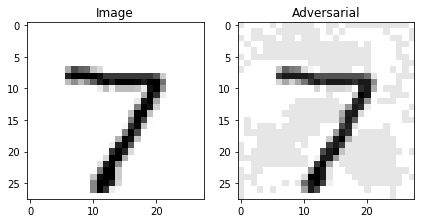

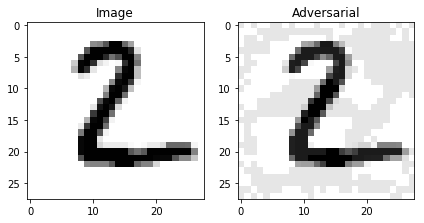

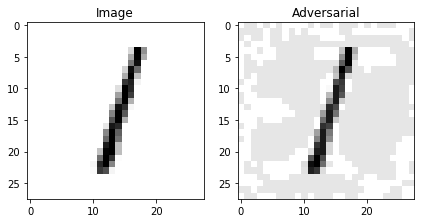

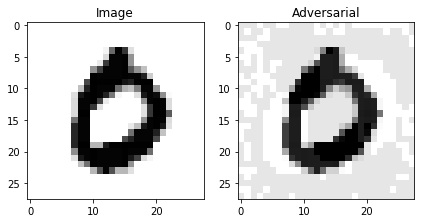

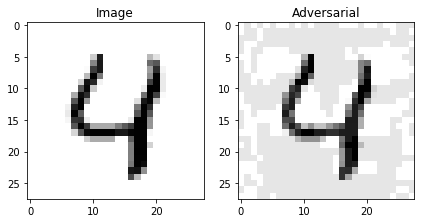

In [7]:
num_adversarials = 100
image_logReg, adver_logReg = model_logisticReg.generate_adversarial(
                                                model_logisticReg,
                                                test_dataset.test_data[0:num_adversarials],
                                                test_dataset.test_labels[0:num_adversarials].reshape(-1))

print ('..........Visualize 5 sample images and corresponding adversarials...........\n')
model_logisticReg.visualize_image_and_adversarial(image_array=image_logReg[0:5].detach().numpy(),
                                                 adversarial_array=adver_logReg[0:5].detach().numpy(),
                                                 results=None)

## Task 4: Evaluating the effects of the adversarial images on Logistic Regression:

..............Adversarial attack on Logistic Regression............



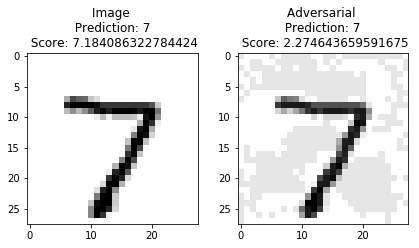

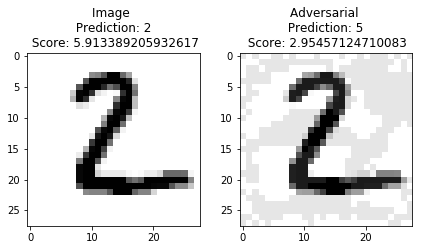

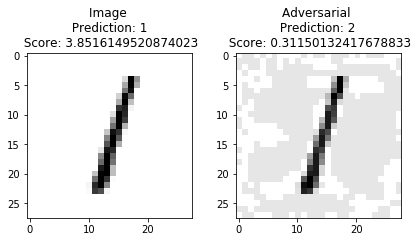

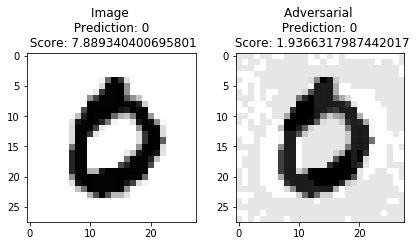

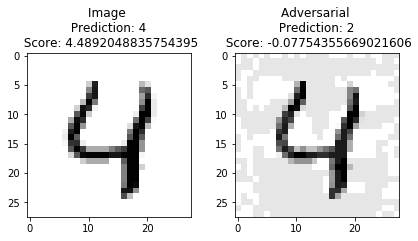

------------------------------------------------------------------
Accuracy on actual images: 93.0
Accuracy on adversarial images: 11.0


In [8]:
results = model_logisticReg.evaluate_adversarial_effect(
                                            model_logisticReg, image_logReg, 
                                            adver_logReg, 
                                            test_dataset.test_labels[0:num_adversarials].reshape(-1))
print ('..............Adversarial attack on Logistic Regression............\n')
model_logisticReg.visualize_image_and_adversarial(results=results, num_visualize=5)
print ('------------------------------------------------------------------')
print ('Accuracy on actual images: {}'.format(results['acc_img']))
print ('Accuracy on adversarial images: {}'.format(results['acc_adv']))

## Task 4: Generating 100 adversarial images for SVM:

..........Visualize 5 sample images and corresponding adversarials...........



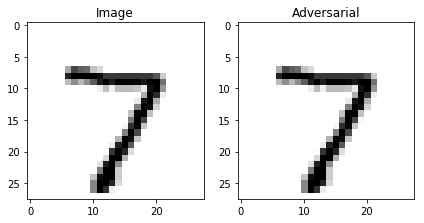

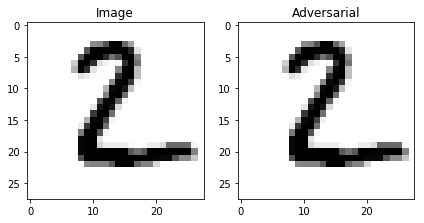

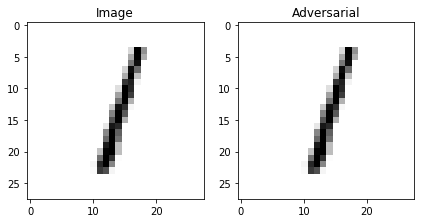

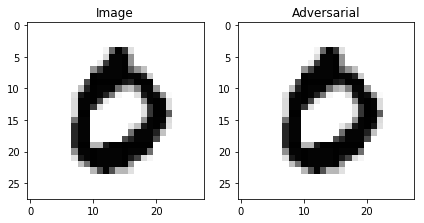

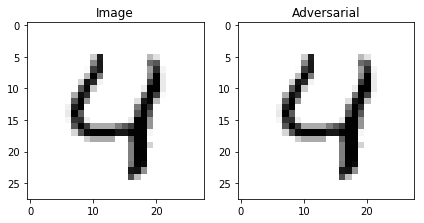

In [9]:
num_adversarials = 100
image_svm, adver_svm = model_SVM.generate_adversarial(
                                                model_SVM,
                                                test_dataset.test_data[0:num_adversarials],
                                                test_dataset.test_labels[0:num_adversarials].reshape(-1),
                                                epsilon=0.5)

print ('..........Visualize 5 sample images and corresponding adversarials...........\n')
model_SVM.visualize_image_and_adversarial(image_array=image_svm[0:5].detach().numpy(),
                                                 adversarial_array=adver_svm[0:5].detach().numpy(),
                                                 results=None)

## Task 4: Evaluating the effects of the adversarial images on SVM:

..............Adversarial attack on Support Vector Machine............



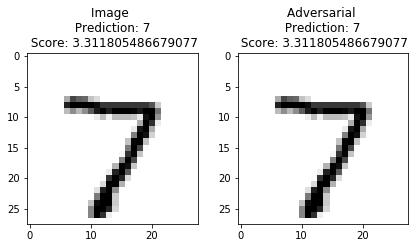

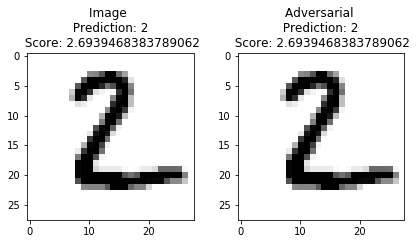

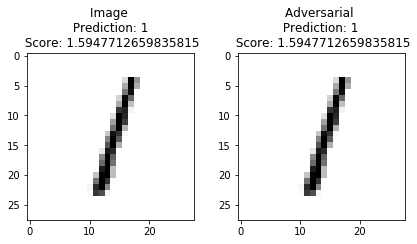

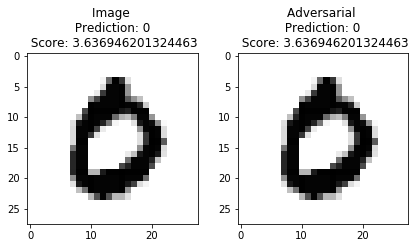

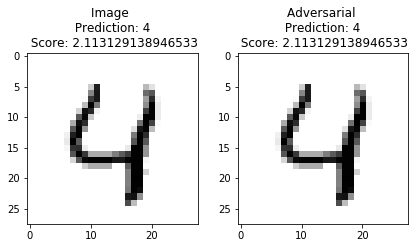

------------------------------------------------------------------
Accuracy on actual images: 95.0
Accuracy on adversarial images: 72.0


In [10]:
results = model_SVM.evaluate_adversarial_effect(
                                            model_SVM, image_svm, 
                                            adver_svm, 
                                            test_dataset.test_labels[0:num_adversarials].reshape(-1))
print ('..............Adversarial attack on Support Vector Machine............\n')
model_SVM.visualize_image_and_adversarial(results=results, num_visualize=5)
print ('------------------------------------------------------------------')
print ('Accuracy on actual images: {}'.format(results['acc_img']))
print ('Accuracy on adversarial images: {}'.format(results['acc_adv']))

## Task 5: Testing models by interchanging generated adversarials:

In [11]:
print ('.....Testing Logistic Regression on adversarial images generated from SVM...\n')

results = model_logisticReg.evaluate_adversarial_effect(
                                            model_logisticReg, image_svm, 
                                            adver_svm, 
                                            test_dataset.test_labels[0:num_adversarials].reshape(-1))
print ('Accuracy on actual images: {}'.format(results['acc_img']))
print ('Accuracy on adversarial images: {}'.format(results['acc_adv']))

.....Testing Logistic Regression on adversarial images generated from SVM...

Accuracy on actual images: 93.0
Accuracy on adversarial images: 72.0


In [12]:
print ('.....Testing SVM on adversarial images generated from Logistic Regression...\n')

results = model_SVM.evaluate_adversarial_effect(
                                            model_SVM, image_logReg, 
                                            adver_logReg, 
                                            test_dataset.test_labels[0:num_adversarials].reshape(-1))
print ('Accuracy on actual images: {}'.format(results['acc_img']))
print ('Accuracy on adversarial images: {}'.format(results['acc_adv']))

.....Testing SVM on adversarial images generated from Logistic Regression...

Accuracy on actual images: 95.0
Accuracy on adversarial images: 6.0


## Task 6: Generating 60000 adversarials and creating new training set:

In [13]:
num_adversarials = 60000
image_logReg, adver_logReg = model_logisticReg.generate_adversarial(
                                                model_logisticReg,
                                                train_dataset.train_data[0:num_adversarials],
                                                train_dataset.train_labels[0:num_adversarials].reshape(-1))

adver_logReg = torch.reshape(adver_logReg, (-1, 28, 28))
normalized_train_data = train_dataset.train_data.type(torch.FloatTensor)/255.
train_dataset.train_data = torch.cat((normalized_train_data, adver_logReg), dim=0) * 255
train_dataset.train_labels = torch.cat((train_dataset.train_labels[0:num_adversarials],
                                       train_dataset.train_labels[0:num_adversarials]), dim=0) 
print('Shape of new training data: {}'.format(
                        train_dataset.train_data.shape))
print('Shape of new training labels: {}'.format(
                        train_dataset.train_labels.shape))

Shape of new training data: torch.Size([120000, 28, 28])
Shape of new training labels: torch.Size([120000])


## Task 6: Retraining and evaluating the two models:

In [14]:
print ('...........Logistic Regression..............\n')

model_logisticReg = LinearModel(input_dim, output_dim, algorithm_name='LogisticRegression')
model_logisticReg.fit_and_evaluate(model_logisticReg, train_dataset, 
                                   test_dataset.test_data, test_dataset.test_labels)

...........Logistic Regression..............

Epoch: 1. Training Loss: 1.1657236814498901. Test Accuracy: 14.32
Epoch: 2. Training Loss: 1.1167799234390259. Test Accuracy: 14.81
Epoch: 3. Training Loss: 1.0219694375991821. Test Accuracy: 14.16
Epoch: 4. Training Loss: 0.9923308491706848. Test Accuracy: 13.27
Epoch: 5. Training Loss: 0.839326798915863. Test Accuracy: 12.61
Epoch: 6. Training Loss: 0.8311876058578491. Test Accuracy: 11.69
Epoch: 7. Training Loss: 0.8361297845840454. Test Accuracy: 11.16
Epoch: 8. Training Loss: 0.7912066578865051. Test Accuracy: 10.77
Epoch: 9. Training Loss: 0.8634053468704224. Test Accuracy: 10.64
Epoch: 10. Training Loss: 0.7733713388442993. Test Accuracy: 10.37


In [15]:
print ('...........Support Vector Machine..............\n')

model_SVM = LinearModel(input_dim, output_dim, algorithm_name='SVM')
model_SVM.fit_and_evaluate(model_SVM, train_dataset, 
                           test_dataset.test_data, test_dataset.test_labels)

...........Support Vector Machine..............

Epoch: 1. Training Loss: 3.5574769973754883. Test Accuracy: 14.84
Epoch: 2. Training Loss: 2.800982713699341. Test Accuracy: 12.35
Epoch: 3. Training Loss: 2.3519675731658936. Test Accuracy: 10.96
Epoch: 4. Training Loss: 2.1461479663848877. Test Accuracy: 10.42
Epoch: 5. Training Loss: 1.8605360984802246. Test Accuracy: 10.23
Epoch: 6. Training Loss: 1.899336576461792. Test Accuracy: 10.2
Epoch: 7. Training Loss: 1.9729762077331543. Test Accuracy: 10.21
Epoch: 8. Training Loss: 1.819486379623413. Test Accuracy: 10.22
Epoch: 9. Training Loss: 1.580538034439087. Test Accuracy: 10.15
Epoch: 10. Training Loss: 1.8695851564407349. Test Accuracy: 10.15


## Task 6: 1) Both the models performed worse on the new dataset.  

## Task 6: 2) Adversarial attack on the new trained model: From the accuracy we can see that the new model is more susceptable to the adverserial examples.

## Task 6: 3) Could regularization be used: Yes regularization can be used because the model has less accuracy because of over fitting. The model is trying to in corporate even the smallest of the noise. In order to avoid this, we need to perform regularization. 
